<a href="https://colab.research.google.com/github/ThiagoMartinsThome/Time_Series/blob/master/ForecastingStocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
!git clone 'https://github.com/PracticalTimeSeriesAnalysis/BookRepo'

fatal: destination path 'BookRepo' already exists and is not an empty directory.


In [3]:
!pwd
%ls
%cd BookRepo/

/content
BookRepo/  sample_data/
/content/BookRepo


In [0]:
from google.colab import files

In [4]:
uploaded = files.upload()

Saving sp500.csv to sp500.csv


In [0]:
%matplotlib inline

width = 6
height = 3
import matplotlib
matplotlib.rcParams['figure.figsize'] = [width, height]

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import math
import pdb

import tensorflow as tf

import sklearn
import sklearn.preprocessing

import numpy as np
import pandas as pd

from scipy.stats import pearsonr, spearmanr


## Exercise:  Look at the data

In [0]:
## we download historical data from 1990-2019
## from Yahoo https://finance.yahoo.com/quote/%5EGSPC/history?period1=634885200&period2=1550034000&interval=1d&filter=history&frequency=1d

In [0]:
df = pd.read_csv("sp500.csv")

In [9]:
df.shape

(7530, 7)

In [10]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1990-02-13,330.079987,331.609985,327.920013,331.019989,331.019989,144490000
1,1990-02-14,331.019989,333.200012,330.640015,332.010010,332.010010,138530000
2,1990-02-15,332.010010,335.209991,331.609985,334.890015,334.890015,174620000
3,1990-02-16,334.890015,335.640015,332.420013,332.720001,332.720001,166840000
4,1990-02-20,332.720001,332.720001,326.260010,327.989990,327.989990,147300000


In [11]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
7525,2019-12-26,3227.199951,3240.080078,3227.199951,3239.909912,3239.909912,2160680000
7526,2019-12-27,3247.229980,3247.929932,3234.370117,3240.020020,3240.020020,2428670000
7527,2019-12-30,3240.090088,3240.919922,3216.570068,3221.290039,3221.290039,3013290000
7528,2019-12-31,3215.179932,3231.719971,3212.030029,3230.780029,3230.780029,2893810000
7529,2020-01-02,3244.669922,3258.139893,3235.530029,3257.850098,3257.850098,3458250000


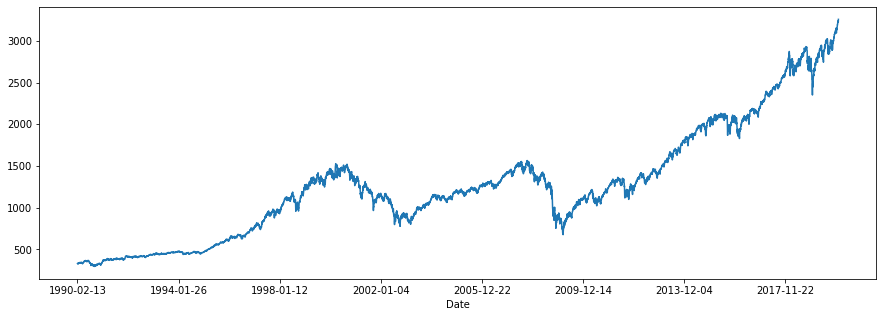

In [12]:
## let's first take a look at our data
df.index = df.Date
plt.rcParams["figure.figsize"] = (15, 5)
fig = df.Close.plot()

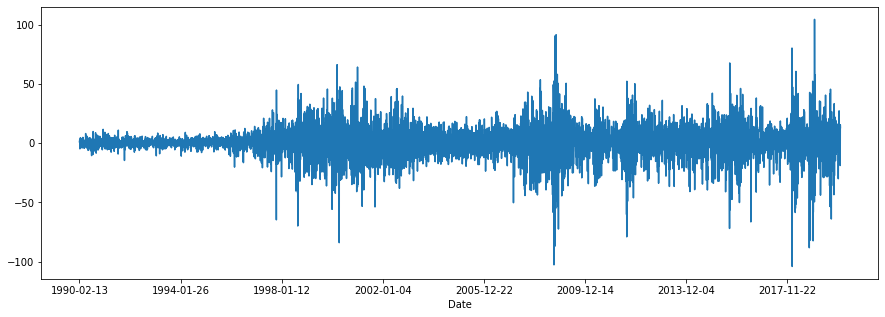

In [13]:
(df.Close - df.Open).plot()

In [0]:
## we can see there have been several "regime changes"
## although it would be difficult to set an exact date of the change
## but do different weeks look all that different?

([<matplotlib.axis.XTick at 0x7f4f02bd7048>,
 <a list of 5 Text major ticklabel objects>)

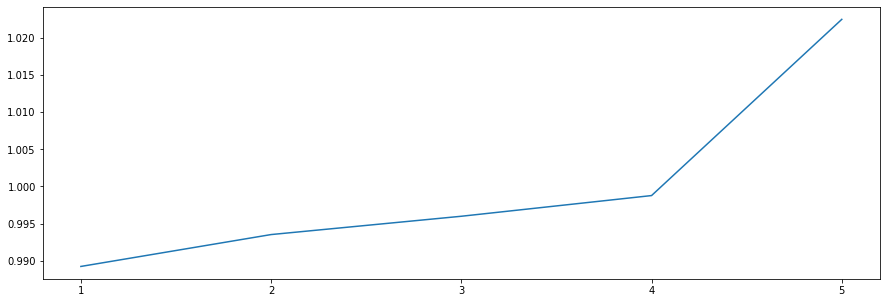

In [15]:
vals = df["1990-05-05":"1990-05-11"].Close.values
mean_val = np.mean(vals)
plt.plot([1, 2, 3, 4, 5], vals/mean_val)
plt.xticks([1, 2, 3, 4, 5])

([<matplotlib.axis.XTick at 0x7f4f02b36b38>,
 <a list of 5 Text major ticklabel objects>)

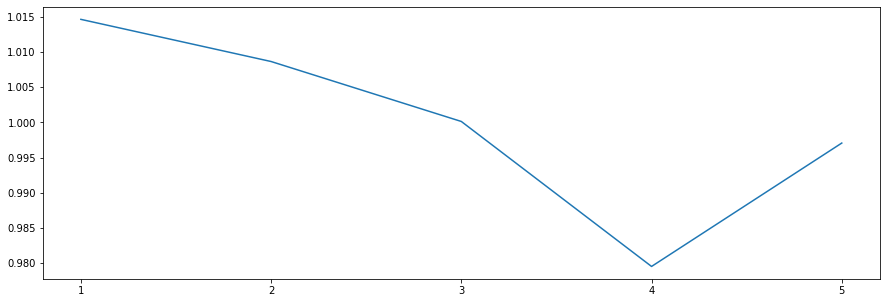

In [16]:
vals = df["2000-05-05":"2000-05-11"].Close.values
mean_val = np.mean(vals)
plt.plot([1, 2, 3, 4, 5], vals/mean_val)
plt.xticks([1, 2, 3, 4, 5])

vals = df["2010-05-05":"2010-05-12"].Close.values
mean_val = np.mean(vals)
plt.plot(vals/mean_val)

([<matplotlib.axis.XTick at 0x7f4f02b13c50>,
 <a list of 5 Text major ticklabel objects>)

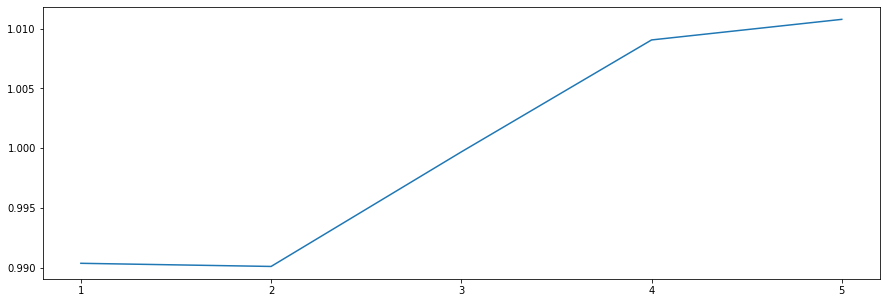

In [17]:
vals = df["2018-05-05":"2018-05-11"].Close.values
mean_val = np.mean(vals)
plt.plot([1, 2, 3, 4, 5], vals/mean_val)
plt.xticks([1, 2, 3, 4, 5])

In [0]:
## if we evaluate in terms of percent change within the week 
## none of these weeks seem distinctly different at the week-based scale to the eye

## Data Preprocessing

In [0]:
## We will use a deep learning approach, so we need to normalize our inputs to fall 
## within -1 to 1. we want to do so without letting information leak backwards from the future
## so we need to have a rolling smoothing process rather than taking the global mean to normalize
## these columns

In [0]:
## we want to predict daily returns (imagine you choose only to buy at start of day 
## and sell at end of day)

In [21]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
1990-02-13,1990-02-13,330.079987,331.609985,327.920013,331.019989,331.019989,144490000
1990-02-14,1990-02-14,331.019989,333.200012,330.640015,332.010010,332.010010,138530000
1990-02-15,1990-02-15,332.010010,335.209991,331.609985,334.890015,334.890015,174620000
1990-02-16,1990-02-16,334.890015,335.640015,332.420013,332.720001,332.720001,166840000
1990-02-20,1990-02-20,332.720001,332.720001,326.260010,327.989990,327.989990,147300000


In [0]:
df['Return'] = df.Close - df.Open

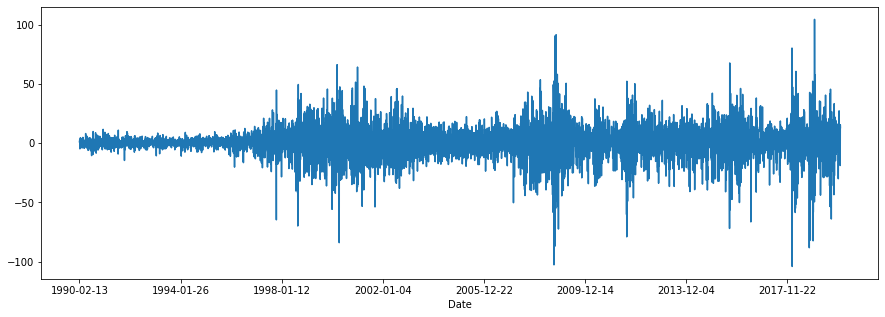

In [23]:
df.Return.plot()

In [0]:
df['DailyVolatility'] = df.High - df.Low

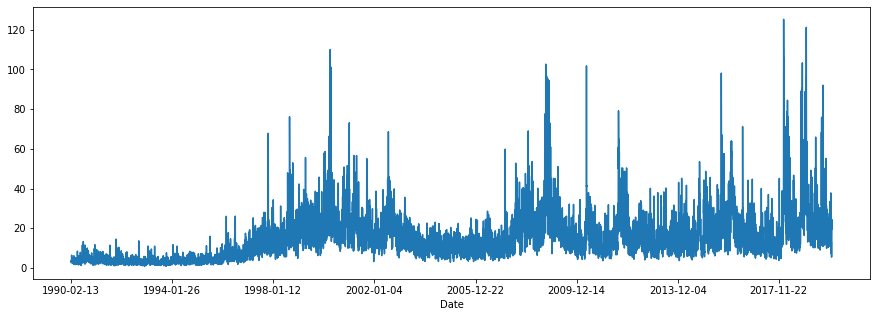

In [25]:
df.DailyVolatility.plot()

In [0]:
## as our inputs we will use daily volatility, daily return, and daily volume
## all should be scaled appropriately so we need to compute rolling means to scale these

In [0]:
## we will use an exponentially weighted moving average

In [0]:
ewdf = df.ewm(halflife = 10).mean()

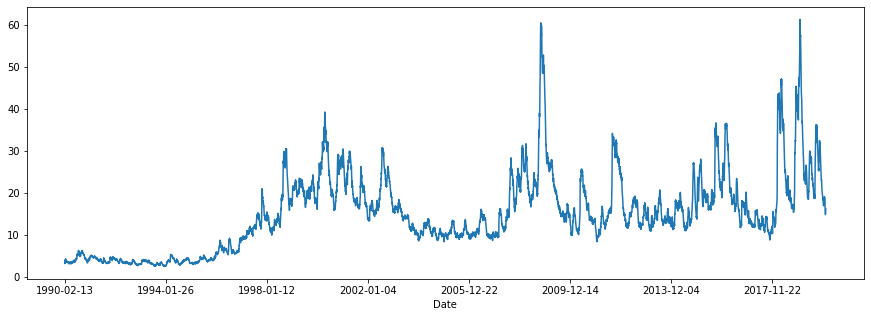

In [29]:
ewdf.DailyVolatility.plot()

In [0]:
vewdf = df.ewm(halflife = 10).var()

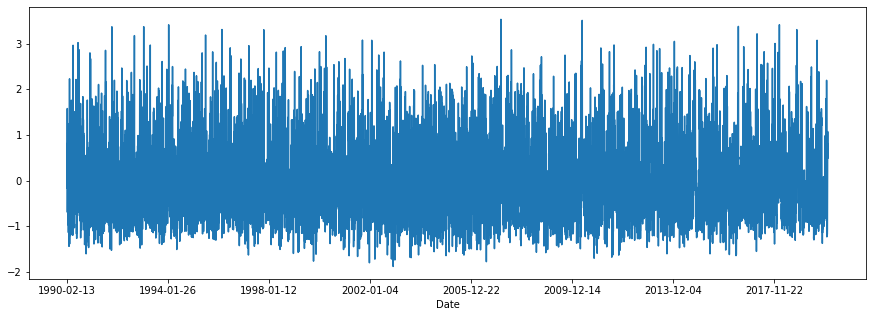

In [31]:
## notice that we don't fit to the smoothed values we merely use them to 
((df.DailyVolatility - ewdf.DailyVolatility)/ vewdf.DailyVolatility**0.5 ).plot()

In [0]:
df['ScaledVolatility'] = ((df.DailyVolatility - ewdf.DailyVolatility)/ vewdf.DailyVolatility**0.5 )

In [33]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Return,DailyVolatility,ScaledVolatility
Date,,,,,,,,,,
1990-02-13,1990-02-13,330.079987,331.609985,327.920013,331.019989,331.019989,144490000,0.940002,3.689972,NaN
1990-02-14,1990-02-14,331.019989,333.200012,330.640015,332.010010,332.010010,138530000,0.990021,2.559997,-0.682610
1990-02-15,1990-02-15,332.010010,335.209991,331.609985,334.890015,334.890015,174620000,2.880005,3.600006,0.507880
1990-02-16,1990-02-16,334.890015,335.640015,332.420013,332.720001,332.720001,166840000,-2.170014,3.220002,-0.088831
1990-02-20,1990-02-20,332.720001,332.720001,326.260010,327.989990,327.989990,147300000,-4.730011,6.459991,1.577997


In [0]:
df['ScaledReturn'] = ((df.Return - ewdf.Return)/ vewdf.Return**0.5 )

In [0]:
df['ScaledVolume'] = ((df.Volume - ewdf.Volume)/ vewdf.Volume**0.5 )

In [36]:
df.head(12)

,Date,Open,High,Low,Close,Adj Close,Volume,Return,DailyVolatility,ScaledVolatility,ScaledReturn,ScaledVolume
Date,,,,,,,,,,,,
1990-02-13,1990-02-13,330.079987,331.609985,327.920013,331.019989,331.019989,144490000,0.940002,3.689972,NaN,NaN,NaN
1990-02-14,1990-02-14,331.019989,333.200012,330.640015,332.010010,332.010010,138530000,0.990021,2.559997,-0.682610,0.682610,-0.682610
1990-02-15,1990-02-15,332.010010,335.209991,331.609985,334.890015,334.890015,174620000,2.880005,3.600006,0.507880,1.095396,1.083513
1990-02-16,1990-02-16,334.890015,335.640015,332.420013,332.720001,332.720001,166840000,-2.170014,3.220002,-0.088831,-1.272816,0.567948
1990-02-20,1990-02-20,332.720001,332.720001,326.260010,327.989990,327.989990,147300000,-4.730011,6.459991,1.577997,-1.320389,-0.486045
1990-02-21,1990-02-21,327.910004,328.170013,324.470001,327.670013,327.670013,159240000,-0.239991,3.700012,-0.172130,0.112849,0.261347
1990-02-22,1990-02-22,327.670013,330.980011,325.700012,325.700012,325.700012,184320000,-1.970001,5.279999,0.820098,-0.465662,1.393322
1990-02-23,1990-02-23,325.700012,326.149994,322.100006,324.149994,324.149994,148490000,-1.550018,4.049988,-0.082992,-0.275037,-0.635063
1990-02-26,1990-02-26,324.160004,328.670013,323.980011,328.670013,328.670013,148900000,4.510009,4.690002,0.401505,1.583178,-0.551605


In [37]:
df.shape

(7530, 12)

In [0]:
## remove first row, which has na
df = df.dropna()

In [0]:
## now we need to form input arrays and target arrays
## let's try to predict just a day ahead and see how we do
## predicting stock prices is notoriously difficult so we should not
## get ahead of ourselves

In [0]:
train_df = df[:7000]
test_df = df[7000:]
X = train_df[:(7000 - 10)][["ScaledVolatility", "ScaledReturn", "ScaledVolume"]].values
Y = train_df[10:]["ScaledReturn"].values


In [0]:
## however batches are usually in form TNC
## time, num examples, channels
## so we need to reshape

In [42]:
X.shape

(6990, 3)

In [0]:
X = np.expand_dims(X, axis = 1)

In [44]:
X.shape

(6990, 1, 3)

## Exercise: reshape X into 'TNC' form with numpy operations

In [0]:
X = np.split(X, X.shape[0]/10, axis = 0)

In [0]:
X = np.concatenate(X, axis = 1)

In [47]:
X.shape

(10, 699, 3)

In [48]:
X[:, 0, 1]

array([ 0.68261013,  1.09539587, -1.2728162 , -1.32038878,  0.1128491 ,
       -0.46566243, -0.27503675,  1.5831776 ,  0.53311559,  0.50715858])

In [49]:
X[:, 1, 1]

array([ 0.1992625 ,  0.8803464 , -0.88575025,  1.31202992, -0.62081656,
        0.9699946 , -1.06775852,  0.06323974, -1.17051705,  0.21707769])

In [50]:
X[:, 2, 1]

array([ 0.33628914,  1.29029955,  0.35875567, -1.0627572 , -0.92827774,
       -1.57810457,  0.55630126,  0.10533493,  1.35843311,  0.02266415])

In [51]:
train_df[:(7000 - 10)][["ScaledReturn"]].values[:31]

array([[ 0.68261013],
       [ 1.09539587],
       [-1.2728162 ],
       [-1.32038878],
       [ 0.1128491 ],
       [-0.46566243],
       [-0.27503675],
       [ 1.5831776 ],
       [ 0.53311559],
       [ 0.50715858],
       [ 0.1992625 ],
       [ 0.8803464 ],
       [-0.88575025],
       [ 1.31202992],
       [-0.62081656],
       [ 0.9699946 ],
       [-1.06775852],
       [ 0.06323974],
       [-1.17051705],
       [ 0.21707769],
       [ 0.33628914],
       [ 1.29029955],
       [ 0.35875567],
       [-1.0627572 ],
       [-0.92827774],
       [-1.57810457],
       [ 0.55630126],
       [ 0.10533493],
       [ 1.35843311],
       [ 0.02266415],
       [-0.64458727]])

In [0]:
Y_test = Y[::10]

In [53]:
Y_test[:3]

array([ 0.1992625 ,  0.33628914, -0.64458727])

In [0]:
Y = Y_test

In [55]:
X.shape

(10, 699, 3)

In [56]:
Y.shape

(699,)

In [0]:
## notice that we only used each data point once
## but actually each data point can belong to many series, occupying a different position in the series
## say it could be the first point or the last point or a middle point in the time series
## rather than explicitly expanding out, we will simply cut off a random number of points
## at each end so that for each epoch through training, we'll have different series

## Build the neural network

In [0]:
NUM_HIDDEN    = 8
NUM_LAYERS    = 1
LEARNING_RATE = 1e-2
EPOCHS        = 10
BATCH_SIZE    = 64
WINDOW_SIZE   = 20

In [0]:
#tf.compat.v1.disable_eager_execution()

Xinp = tf.placeholder(dtype = tf.float32, shape = [WINDOW_SIZE, None, 3])
Yinp = tf.placeholder(dtype = tf.float32, shape = [None])

In [60]:
with tf.variable_scope("scope1", reuse=tf.AUTO_REUSE):
    #rnn_cell = tf.nn.rnn_cell.LSTMCell(NUM_HIDDEN, dtype = tf.float32)
    #rnn_cell = tf.nn.rnn_cell.DropoutWrapper(rnn_cell, output_keep_prob=0.9)
    #rnn_output, states = tf.nn.dynamic_rnn(rnn_cell, Xinp, dtype=tf.float32) 
    
    ## tf.nn.rnn_cell.MultiRNNCell
    cells = [tf.nn.rnn_cell.LSTMCell(num_units=NUM_HIDDEN) for n in range(NUM_LAYERS)]
    stacked_rnn_cell = tf.nn.rnn_cell.MultiRNNCell(cells)
    rnn_output, states = tf.nn.dynamic_rnn(stacked_rnn_cell, Xinp, dtype=tf.float32) 
    W = tf.get_variable("W_fc", [NUM_HIDDEN, 1], initializer = tf.random_uniform_initializer(-.2, .2))
    output = tf.squeeze(tf.matmul(rnn_output[-1, :, :], W))
    ## notice we have no bias because we expect average zero return
    loss = tf.nn.l2_loss(output - Yinp)
    opt = tf.train.GradientDescentOptimizer(LEARNING_RATE)
    ##opt = tf.train.AdamOptimizer(LEARNING_RATE)
    train_step = opt.minimize(loss)

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
## need to loop through data and find a way to jitter data 
## then need to also compute validation loss
## and need to record results

In [0]:
sess = tf.Session()
sess.run(tf.tables_initializer())
sess.run(tf.global_variables_initializer())

In [63]:
## for each epoch
y_hat_dict = {}
Y_dict = {}

in_sample_Y_dict = {}
in_sample_y_hat_dict = {}

for ep in range(EPOCHS):
    ## for each offset to create a new series of distinct time series 
    ## (re: overlapping issue we talked about previously)
    epoch_training_loss = 0.0
    for i in range(WINDOW_SIZE):
        X = train_df[:(7000 - WINDOW_SIZE)][["ScaledVolatility", "ScaledReturn", "ScaledVolume"]].values
        Y = train_df[WINDOW_SIZE:]["ScaledReturn"].values

        ## make it divisible by window size
        num_to_unpack = math.floor(X.shape[0] / WINDOW_SIZE)
        start_idx = X.shape[0] - num_to_unpack * WINDOW_SIZE
        X = X[start_idx:] 
        Y = Y[start_idx:]  
        
        X = X[i:-(WINDOW_SIZE-i)]
        Y = Y[i:-(WINDOW_SIZE-i)]                                
        
        X = np.expand_dims(X, axis = 1)
        X = np.split(X, X.shape[0]/WINDOW_SIZE, axis = 0)
        X = np.concatenate(X, axis = 1)
        Y = Y[::WINDOW_SIZE]
        ## TRAINING
        ## now batch it and run a sess
        for j in range(math.ceil(Y.shape[0] / BATCH_SIZE)):
            ll = BATCH_SIZE * j
            ul = BATCH_SIZE * (j + 1)
            
            if ul > X.shape[1]:
                ul = X.shape[1] - 1
                ll = X.shape[1]- BATCH_SIZE
            
            training_loss, _, y_hat = sess.run([loss, train_step, output],
                                       feed_dict = {
                                           Xinp: X[:, ll:ul, :], Yinp: Y[ll:ul]
                                       })
            epoch_training_loss += training_loss          
            
            in_sample_Y_dict[ep]     = Y[ll:ul] ## notice this will only net us the last part of data trained on
            in_sample_y_hat_dict[ep] = y_hat
            
        ## TESTING
        X = test_df[:(test_df.shape[0] - WINDOW_SIZE)][["ScaledVolatility", "ScaledReturn", "ScaledVolume"]].values
        Y = test_df[WINDOW_SIZE:]["ScaledReturn"].values
        num_to_unpack = math.floor(X.shape[0] / WINDOW_SIZE)
        start_idx = X.shape[0] - num_to_unpack * WINDOW_SIZE
        X = X[start_idx:] ## better to throw away beginning than end of training period when must delete
        Y = Y[start_idx:]                              
        
        X = np.expand_dims(X, axis = 1)
        X = np.split(X, X.shape[0]/WINDOW_SIZE, axis = 0)
        X = np.concatenate(X, axis = 1)
        Y = Y[::WINDOW_SIZE]
        testing_loss, y_hat = sess.run([loss, output],
                                 feed_dict = { Xinp: X, Yinp: Y })
        ## nb this is not great. we should really have a validation loss apart from testing
        
    print("Epoch: %d   Training loss: %0.2f   Testing loss %0.2f:" % (ep, epoch_training_loss, testing_loss))
    Y_dict[ep] = Y
    y_hat_dict[ep] = y_hat
    

Epoch: 0   Training loss: 3201.30   Testing loss 8.65:
Epoch: 1   Training loss: 3196.34   Testing loss 8.62:
Epoch: 2   Training loss: 3194.38   Testing loss 8.61:
Epoch: 3   Training loss: 3192.84   Testing loss 8.60:
Epoch: 4   Training loss: 3191.45   Testing loss 8.60:
Epoch: 5   Training loss: 3190.14   Testing loss 8.60:
Epoch: 6   Training loss: 3188.88   Testing loss 8.61:
Epoch: 7   Training loss: 3187.66   Testing loss 8.62:
Epoch: 8   Training loss: 3186.47   Testing loss 8.63:
Epoch: 9   Training loss: 3185.31   Testing loss 8.65:


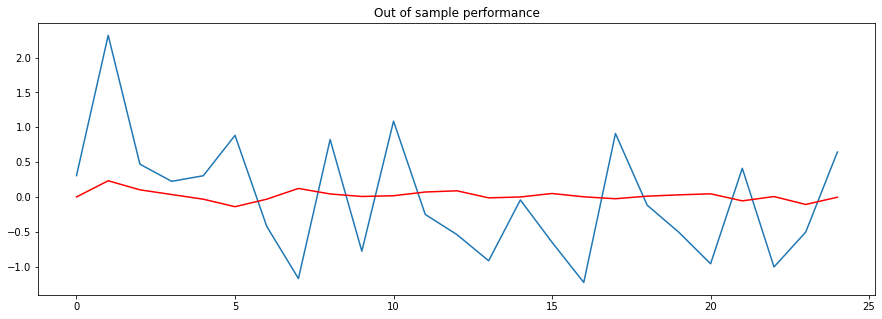

In [64]:
plt.plot(Y_dict[EPOCHS - 1])
plt.plot(y_hat_dict[EPOCHS - 1], 'r')
plt.title('Out of sample performance')
plt.show()

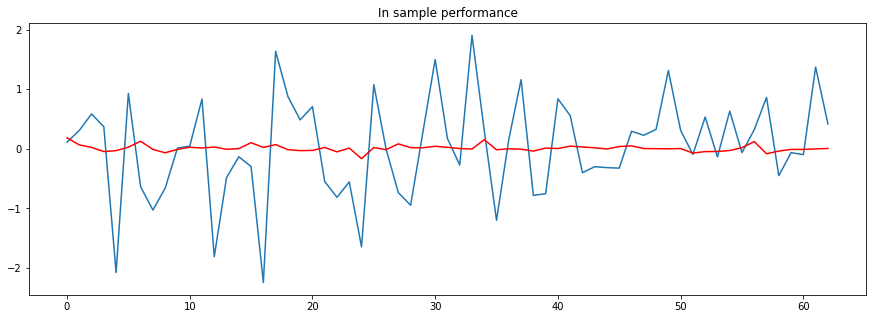

In [65]:
plt.plot(in_sample_Y_dict[EPOCHS - 1])
plt.plot(in_sample_y_hat_dict[EPOCHS - 1], 'r')
plt.title('In sample performance')
plt.show()

In [66]:
pearsonr(Y_dict[EPOCHS - 1], y_hat_dict[EPOCHS - 1])

(0.16215351566970815, 0.4386909898089163)

In [67]:
pearsonr(in_sample_Y_dict[EPOCHS - 1], in_sample_y_hat_dict[EPOCHS - 1])

(0.1342250114198279, 0.2942706925334317)

In [68]:
spearmanr(Y_dict[EPOCHS - 1], y_hat_dict[EPOCHS - 1])

SpearmanrResult(correlation=-0.14076923076923076, pvalue=0.5021146784013018)

In [69]:
spearmanr(in_sample_Y_dict[EPOCHS - 1], in_sample_y_hat_dict[EPOCHS - 1])

SpearmanrResult(correlation=0.08501344086021506, pvalue=0.5076753025973799)

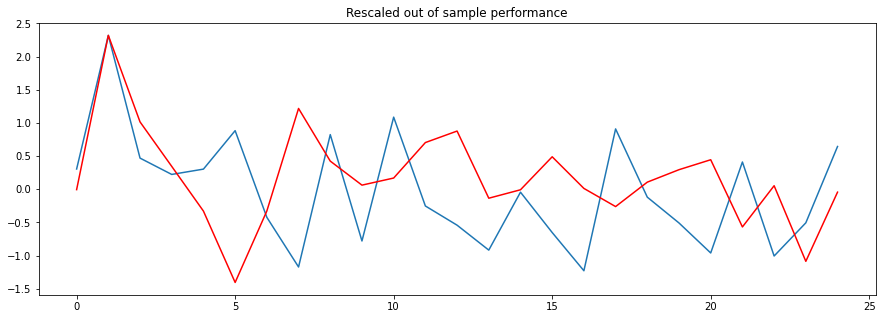

In [70]:
plt.plot(Y_dict[EPOCHS - 1])
plt.plot(y_hat_dict[EPOCHS - 1] * 10, 'r')
plt.title('Rescaled out of sample performance')
plt.show()

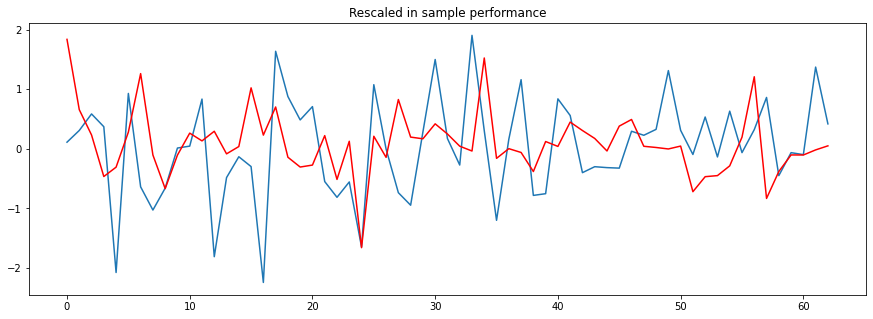

In [71]:
plt.plot(in_sample_Y_dict[EPOCHS - 1])
plt.plot(in_sample_y_hat_dict[EPOCHS - 1] * 10, 'r')
plt.title('Rescaled in sample performance')
plt.show()

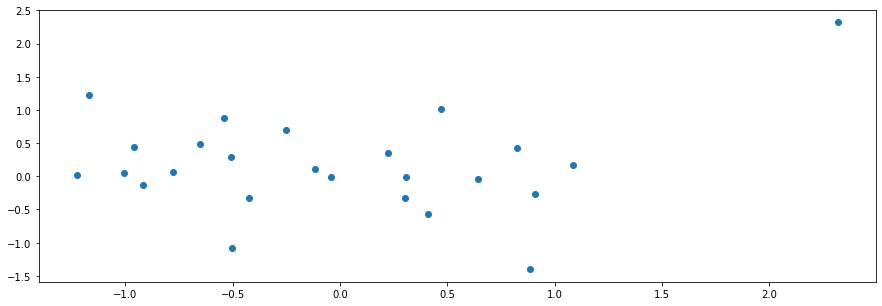

In [72]:
plt.plot(Y_dict[EPOCHS - 1], y_hat_dict[EPOCHS - 1] * 10, linestyle="", marker="o")

In [73]:
pearsonr(Y_dict[EPOCHS - 1], y_hat_dict[EPOCHS - 1])

(0.16215351566970815, 0.4386909898089163)

In [74]:
spearmanr(Y_dict[EPOCHS - 1], y_hat_dict[EPOCHS - 1])

SpearmanrResult(correlation=-0.14076923076923076, pvalue=0.5021146784013018)

In [75]:
in_sample_Y_dict[EPOCHS-1].shape

(63,)